# Perform Cutler-Vallisneri with (IMRPhenomXAS, IMRPhenomD) and CE network

In [4]:
import numpy as np
from gwbench import network
from gwbench import snr

In [20]:
def get_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 1024.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )

    # compute the WF polarizations
    net.calc_wf_polarizations()
    # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    # calculate the network and detector Fisher matrices, condition numbers,
    # covariance matrices, error estimates, and inversion errors
    net.calc_errors()

    # calculate the 90%-credible sky area (in deg)
    net.calc_sky_area_90()

    return net


For given 'true' and 'approximate' waveforms $h_{TR}$ and $h_{AP}$, the systematic error due to waveform inaccuracy on the parameter $\theta^i$ is given by:
$$ \Delta \theta^i = (\Gamma_{AP}^{-1})^{ij} \quad  \Sigma_{D=1}^{N_{det}}  (\partial_j (h_{AP})_D | (h_{TR})_D - (h_{AP})_D)$$


We will assume that IMRPhenomXAS is $h_{TR}$ (net1) and IMRPhenomD is $h_{AP}$ (net2).


In [95]:
# set the injection parameters
inj_params = {
    'Mc':    50.9,
    'eta':   0.247,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': 0,
    'chi2z': 0,
    'DL':    475,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0
    }

deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi'
param_list = deriv_symbs_string.split()

# network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V']
network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


In [22]:
net1 = get_network_response(inj_params=inj_params, network_spec=network_spec, approximant='IMRPhenomXAS')

Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Errors calculated.
Calculate 90% sky area.
Sky area calculated.


In [96]:
print(net1.errs["Mc"])

0.0014285746965535845


In [25]:
net2 = get_network_response(inj_params=inj_params, network_spec=network_spec, approximant='IMRPhenomD')

Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  CE2-40-CBO_C
  CE2-20-CBO_S
  ET_ET1
  ET_ET2
  ET_ET3
Errors calculated.
Calculate 90% sky area.
Sky area calculated.


In [97]:
print(net2.snr)

2192.773335983826


In [47]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Valisneri formalisn
cov_ap = net2.cov
inner_prod = np.zeros(len(param_list))

for d in range(len(network_spec)):
    del_h_ap_all = net2.detectors[d].del_hf
    del_params_j = list(del_h_ap_all.keys())

    h_tr = net1.detectors[d].hf
    h_ap = net2.detectors[d].hf
    psd = net2.detectors[d].psd
    freq_range = net2.detectors[d].f
    df = freq_range[1] - freq_range[0]

    for j, parameter_j in enumerate(del_params_j):
        del_h_ap_j = del_h_ap_all[parameter_j]  
        # Inner Product
        inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
    
# Calculate the theoretical bias across parameters
errors_th = np.dot(cov_ap, inner_prod)

In [137]:
errors_th[0]

0.6310148820052082

# Plot the Bias across parameters

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

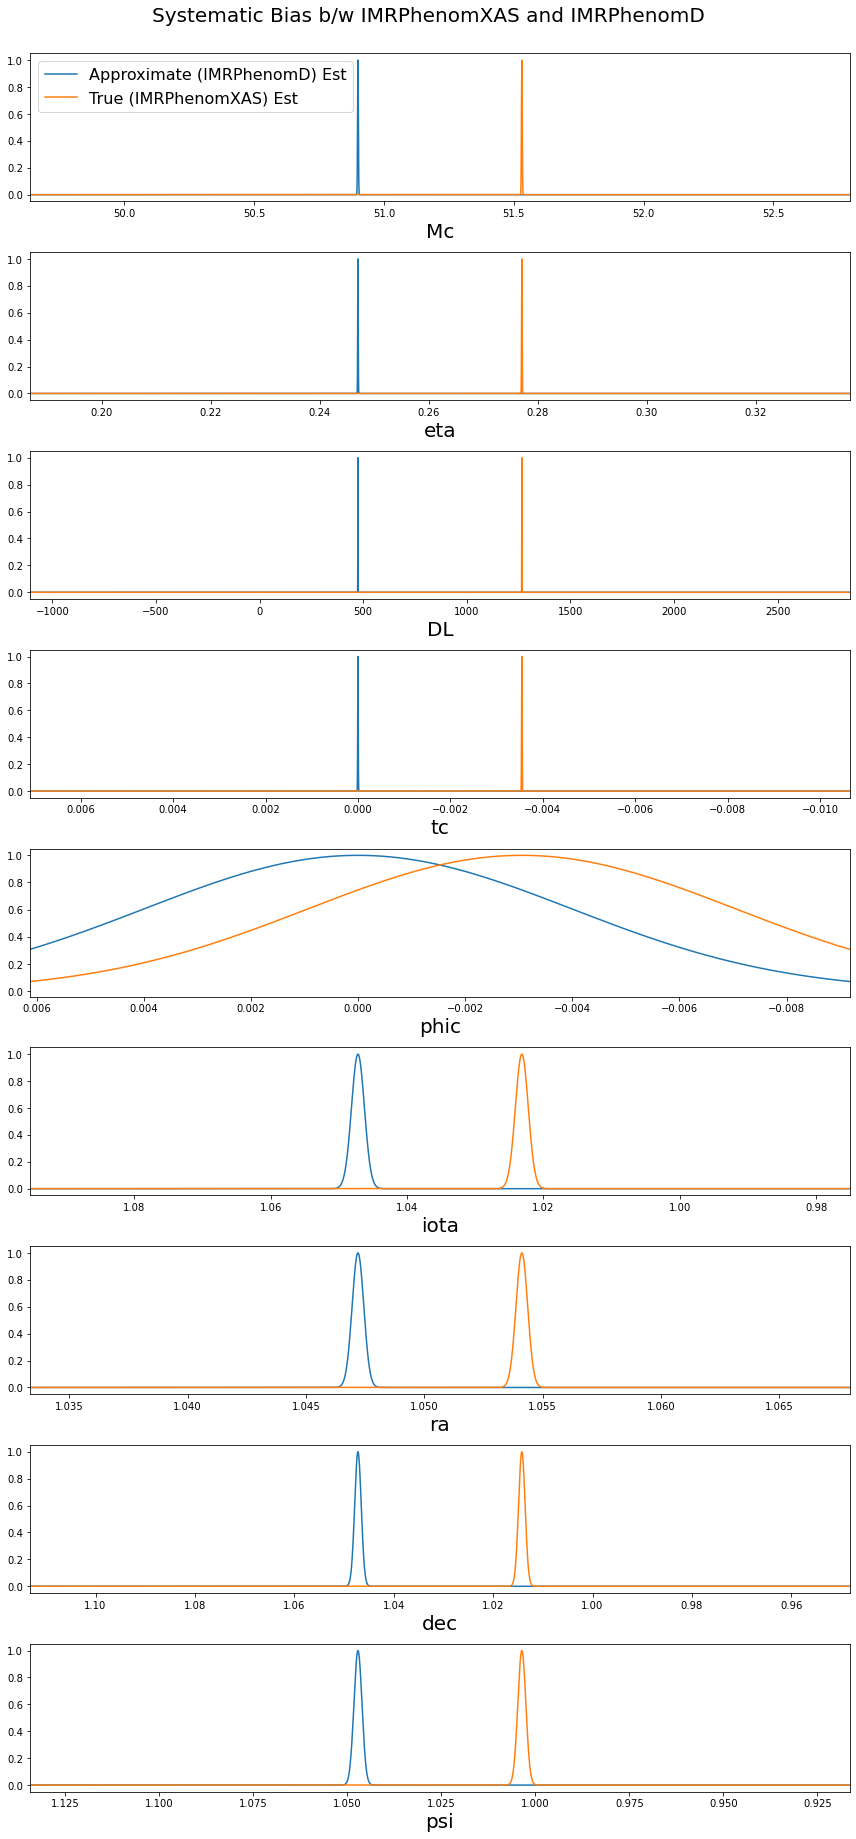

In [136]:

f, (ax)= plt.subplots(len(param_list), 1,  figsize=(12,25)) 

for i, param in enumerate((param_list)):
    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    x = np.linspace(mu-3*errors_th[i], mu+3*errors_th[i], 10000)

    stat_est = stats.norm.pdf(x, mu, sigma)
    stat_est = stat_est/np.max(stat_est)

    theory_est = stats.norm.pdf(x, mu+errors_th[i], sigma)
    theory_est = theory_est/ np.max(theory_est)

    ax[i].plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
    ax[i].plot(x, theory_est, label=f"True (IMRPhenomXAS) Est")
    
    if i==0:
        ax[i].legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=16)

    
    ax[i].set_xlim(mu-2*errors_th[i], mu+3*errors_th[i])
    ax[i].set_xlabel(param, fontsize=20)

plt.suptitle("Systematic Bias b/w IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()